In [18]:
import os
import math
import pandas_datareader as web # stock values
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Reshape

import matplotlib.pyplot as plt
import seaborn as sns
import warnings


%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
company = 'FB'

start = dt.datetime(2012,1,1)
end = dt.datetime(2021,1,1)
df = web.DataReader(company, 'yahoo', start, end)

df


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999
...,...,...,...,...,...,...
2020-12-24,270.399994,266.200012,268.880005,267.399994,6702000,267.399994
2020-12-28,277.299988,265.660004,268.739990,277.000000,23299700,277.000000
2020-12-29,280.510010,276.279999,276.950012,276.779999,16383000,276.779999


In [5]:
dataset = df[['High', 'Low', 'Open' ,'Close']].astype(float)
dataset.head()

,High,Low,Open,Close
Date,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

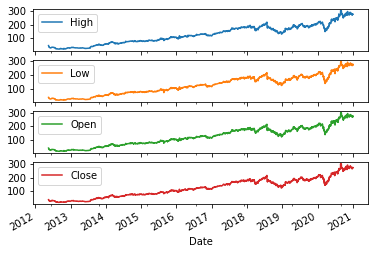

In [132]:
dataset.plot(subplots=True)

In [6]:
# multi variables
cols = list(dataset)
cols

['High', 'Low', 'Open', 'Close']

In [7]:
# Preprocessing + reshape dataset  (time, var, values, channel=1)
scaler =  MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset.values.reshape(-1, len(cols)))

In [8]:
display(pd.DataFrame(scaled_data, columns = cols).head())

,High,Low,Open,Close
0,0.093331,0.074229,0.084976,0.071633
1,0.064211,0.056080,0.065407,0.056957
2,0.053492,0.048603,0.051510,0.046369
3,0.049686,0.050127,0.047114,0.049864
4,0.052165,0.051615,0.052716,0.053463


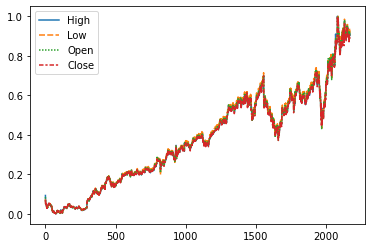

In [9]:
sns.lineplot(data=pd.DataFrame(scaled_data))
plt.legend(labels=cols)

In [10]:
scaled_data.shape

(2170, 4)

In [11]:
# Split train/test data
train_dataset, test_dataset = np.vsplit(scaled_data, [int(len(dataset)*0.8)])


In [12]:
train_dataset.shape, test_dataset.shape

((1736, 4), (434, 4))

In [13]:
display(pd.DataFrame(train_dataset, columns = cols).head())


,High,Low,Open,Close
0,0.093331,0.074229,0.084976,0.071633
1,0.064211,0.056080,0.065407,0.056957
2,0.053492,0.048603,0.051510,0.046369
3,0.049686,0.050127,0.047114,0.049864
4,0.052165,0.051615,0.052716,0.053463


In [14]:
x_train = []
y_train = []

n_past = 20 # Number of past days(time) we want to use to predict future.
n_future = 1 # Number of futures days(time) predict

for i in range(n_past, len(train_dataset)- n_future+1):
    x_train.append(train_dataset[i-n_past:i, 0:train_dataset.shape[1]])
    y_train.append(train_dataset[i+n_future-1:i+n_future, 0:train_dataset.shape[1]])

In [15]:
x_train, y_train = np.array(x_train), np.array(y_train)


In [16]:
x_train.shape, y_train.shape 

((1716, 20, 4), (1716, 1, 4))

In [154]:
display(pd.DataFrame(x_train[1], columns = cols))

,High,Low,Open,Close
0,0.064211,0.056080,0.065407,0.056957
1,0.053492,0.048603,0.051510,0.046369
2,0.049686,0.050127,0.047114,0.049864
3,0.052165,0.051615,0.052716,0.053463
4,0.051257,0.049220,0.052538,0.049549
5,0.046858,0.040290,0.047504,0.038822
6,0.039385,0.037423,0.037649,0.036550
7,0.039804,0.033684,0.037117,0.041477
8,0.037989,0.035717,0.038322,0.034908
9,0.032751,0.032269,0.032331,0.032043


In [155]:
display(pd.DataFrame(y_train[1], columns = cols))

,High,Low,Open,Close
0,0.051082,0.052087,0.050978,0.050667


In [20]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=False))

model.add(Dense(n_future*y_train.shape[2]))
model.add(Reshape([n_future, y_train.shape[2]]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 50)            11000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 84        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 4)             

In [21]:
history = model.fit(x_train, y_train, epochs =50, batch_size=32,
                    validation_split=0.20, verbose=1, shuffle = False)

Epoch 1/50
43/43 [==============================] - 7s 57ms/step - loss: 9.6391e-04 - val_loss: 0.0041
Epoch 2/50
43/43 [==============================] - 1s 34ms/step - loss: 0.0044 - val_loss: 0.0057
Epoch 3/50
43/43 [==============================] - 1s 33ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 4/50
43/43 [==============================] - 1s 32ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 5/50
43/43 [==============================] - 2s 38ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/50
43/43 [==============================] - 1s 32ms/step - loss: 5.4727e-04 - val_loss: 0.0016
Epoch 7/50
43/43 [==============================] - 2s 42ms/step - loss: 4.4967e-04 - val_loss: 0.0015
Epoch 8/50
43/43 [==============================] - 1s 34ms/step - loss: 4.5107e-04 - val_loss: 0.0015
Epoch 9/50
43/43 [==============================] - 1s 33ms/step - loss: 4.2083e-04 - val_loss: 0.0012
Epoch 10/50
43/43 [==============================] - 1s 33ms/step - loss: 4.6644e-04 - va

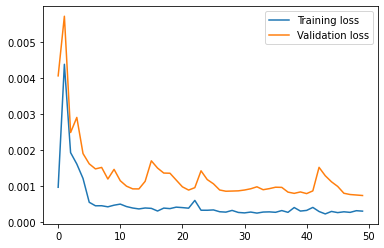

In [22]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [23]:
# forecast
x_test = []
y_test = []

for i in range(n_past, len(test_dataset)- n_future+1):
    x_test.append(test_dataset[i-n_past:i, 0:test_dataset.shape[1]])
    y_test.append(test_dataset[i+n_future-1:i+n_future, 0:test_dataset.shape[1]])

x_test, y_test = np.array(x_test), np.array(y_test)    
x_test.shape

(414, 20, 4)

In [24]:
forecast = model.predict(x_test)

In [25]:
forecast.shape

(414, 1, 4)

In [27]:
forecast = np.reshape(forecast, (-1, forecast.shape[2]))
forecast.shape

(414, 4)

In [28]:
predicted = scaler.inverse_transform(forecast)

In [29]:
predicted.shape

(414, 4)

In [30]:
train_unscaled = scaler.inverse_transform(y_train.reshape(-1, y_train.shape[2]))
test_unscaled = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[2]))

In [31]:
train_unscaled.shape, test_unscaled.shape

((1716, 4), (414, 4))

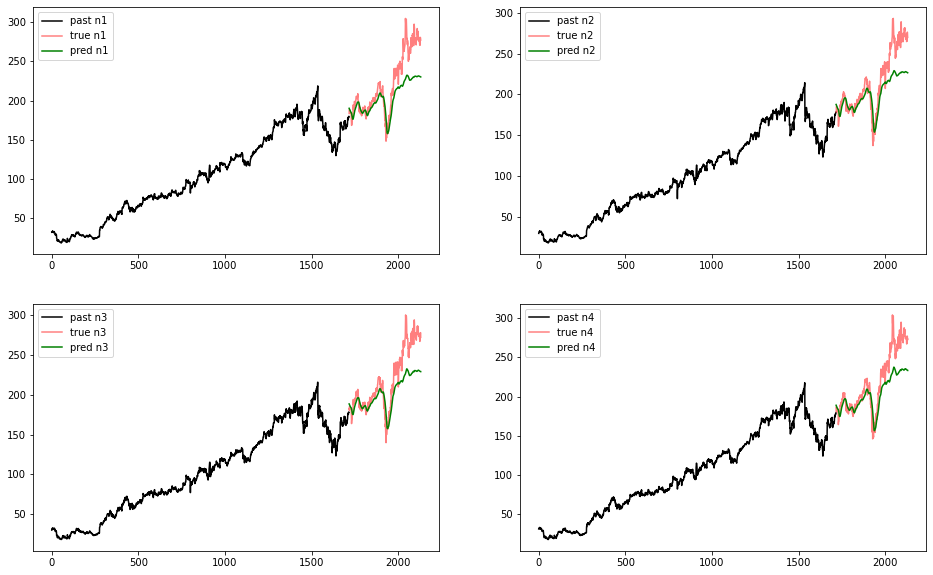

In [32]:
# Check Predictions

a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train)+len(y_test))

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.plot(a_axis, train_unscaled[:,0], color = 'black', label ='past n1')
plt.plot(b_axis, test_unscaled[:,0], color = 'red', alpha=0.5, label ='true n1')
plt.plot(b_axis, predicted[:,0], color = 'green', label ='pred n1')
plt.legend()

plt.subplot(2,2,2)
plt.plot(a_axis, train_unscaled[:,1], color = 'black', label ='past n2')
plt.plot(b_axis, test_unscaled[:,1], color = 'red', alpha=0.5, label ='true n2')
plt.plot(b_axis, predicted[:,1], color = 'green', label ='pred n2')
plt.legend()

plt.subplot(2,2,3)
plt.plot(a_axis, train_unscaled[:,2], color = 'black', label ='past n3')
plt.plot(b_axis, test_unscaled[:,2], color = 'red', alpha=0.5, label ='true n3')
plt.plot(b_axis, predicted[:,2], color = 'green', label ='pred n3')
plt.legend()

plt.subplot(2,2,4)
plt.plot(a_axis, train_unscaled[:,3], color = 'black', label ='past n4')
plt.plot(b_axis, test_unscaled[:,3], color = 'red', alpha=0.5, label ='true n4')
plt.plot(b_axis, predicted[:,3], color = 'green', label ='pred n4')

plt.legend()

plt.show()

In [34]:
import math

testScore = math.sqrt(mean_squared_error(test_unscaled[:,0], predicted[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Test Score: 26.92 RMSE
